# Demonstration of surrogate model capabilities

This is a simple jupyter notebook to demonstrate the autogluon surrogate model capability.

Author: Soheyl Massoudi <smassoudi@ethz.ch>

# Step 1: Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Step 2: Load and Convert Parquet Dataset

In [2]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")

/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset saved to ./data/airfoil_data.csv


In [3]:
dataset.column_names

['initial',
 'optimized',
 'mach',
 'reynolds',
 'cl_target',
 'area_target',
 'alpha',
 'area_initial',
 'cd_val',
 'cl_val',
 'cl_con',
 'area_con']

In [4]:
type(dataset['alpha'])

list

In [5]:
dataset['optimized'][1][0]

[1.0000194365938981,
 0.9897566593945221,
 0.9794544269870155,
 0.9691149136515305,
 0.9587402901643374,
 0.9483327419340516,
 0.9378945048481954,
 0.9274277968572291,
 0.9169348081262216,
 0.9064178020370062,
 0.8958790284346422,
 0.8853207187330372,
 0.8747448930482233,
 0.8641523083004454,
 0.8535437159737151,
 0.8429198967977035,
 0.8322817488654743,
 0.8216301200165563,
 0.8109658171290856,
 0.8002897285258235,
 0.7896027290487984,
 0.7789056461533759,
 0.7681993584263407,
 0.7574847603720507,
 0.7467626918304485,
 0.7360340279427758,
 0.7253037272659675,
 0.7145732743519277,
 0.7038473442473052,
 0.693126502752131,
 0.6824101435303259,
 0.6716976408464019,
 0.6609883248618159,
 0.6502815861483213,
 0.639576822934429,
 0.6288733614389102,
 0.6181705789840656,
 0.6074655520675161,
 0.5967516390819786,
 0.5860288162351749,
 0.5752975145222803,
 0.5645582221285628,
 0.5538114139478776,
 0.5430575344024076,
 0.5322970595788166,
 0.5215304770239737,
 0.5107583657552618,
 0.499988999525

# Step 3: Flatten columns and get X and Y datasets

In [6]:
def recursive_flatten(val):
    """
    Recursively flatten a nested list/tuple into a single list of values.
    E.g. [[x0, x1], [y0, y1]] -> [x0, x1, y0, y1].
    """
    if not isinstance(val, (list, tuple)):
        return [val]
    else:
        result = []
        for item in val:
            result.extend(recursive_flatten(item))
        return result

def flatten_list_columns_nested(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each column in `df` where the first row is a list,
    recursively flatten that column and expand into multiple new numeric columns.
    """
    import pandas as pd
    
    new_cols_list = []
    drop_cols = []
    
    for col in df.columns:
        first_value = df[col].iloc[0]
        # Check if the first row is a list/tuple --> likely all rows are lists
        if isinstance(first_value, (list, tuple)):
            # Flatten each row, store in a temporary list
            flattened_rows = [recursive_flatten(val) for val in df[col]]
            # Ensure consistent length across rows
            lengths = [len(row) for row in flattened_rows]
            unique_lengths = set(lengths)
            if len(unique_lengths) > 1:
                raise ValueError(
                    f"Column '{col}' has rows of varying lengths {unique_lengths}. "
                    "Cannot flatten consistently without special handling."
                )
            # Create new DataFrame with columns [col_0, col_1, ..., col_(n-1)]
            n = lengths[0]
            new_col_names = [f"{col}_{i}" for i in range(n)]
            expanded_df = pd.DataFrame(flattened_rows, columns=new_col_names)
            new_cols_list.append(expanded_df)
            drop_cols.append(col)
    
    if new_cols_list:
        # Drop original list-columns and concatenate new expanded columns
        df = pd.concat(
            [df.drop(columns=drop_cols).reset_index(drop=True)] + new_cols_list,
            axis=1
        )
    return df

# Flatten the nested list columns
df = flatten_list_columns_nested(df)


In [7]:
# The flattened columns for "optimized" will now appear as "optimized_0", "optimized_1", etc.
# Let's find all columns that start with "optimized_"
opt_cols = [col for col in df.columns if col.startswith("optimized_")]

# Or you can do them all if you know the exact count/structure

# Additional numeric columns we want
other_input_cols = ["mach", "reynolds", "alpha"]

# Combine them
feature_cols = opt_cols + other_input_cols

target_col = "cl_val"

# Create X and y
X = df[feature_cols].values
y = df[target_col].values


# Step 4: Split Inputs and Targets

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Suppose X is shape [n_samples, n_features], y is shape [n_samples]
# (Replace with your actual arrays from the flattened dataset.)

# 1) Split off test data (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Split the remaining into train and validation (25% of X_temp = 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}, Test size: {X_test.shape}")

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Optionally scale target as well
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


Train size: (448, 387), Val size: (150, 387), Test size: (150, 387)


# Step 5: Define a Pytorch Dataset and Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train_scaled, y_train_scaled)
val_dataset   = TabularDataset(X_val_scaled,   y_val_scaled)
test_dataset  = TabularDataset(X_test_scaled,  y_test_scaled)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


class SimpleRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(SimpleRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train_scaled.shape[1]  # Number of features
hidden_dim = 64
model = SimpleRegressor(input_dim, hidden_dim, output_dim=1)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model.to(device)

num_epochs = 100
patience = 10  # Early stopping patience
best_val_loss = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses = []

best_model_weights = None
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # --- Training Loop ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch).squeeze(-1)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Loop ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch).squeeze(-1)
            loss = criterion(predictions, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        # Store best weights
        best_model_weights = model.state_dict()
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early stopping condition
    if epochs_no_improve >= patience:
        print(f"Validation loss has not improved for {patience} epochs. Stopping early.")
        break

# --- After training, restore the best weights ---
print(f"Best validation loss = {best_val_loss:.4f} at epoch {best_epoch+1}.")
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)



Using device: mps
Epoch 1/100 - Train Loss: 0.7779, Val Loss: 0.6491
Epoch 2/100 - Train Loss: 0.5426, Val Loss: 0.5571
Epoch 3/100 - Train Loss: 0.4203, Val Loss: 0.4517
Epoch 4/100 - Train Loss: 0.3566, Val Loss: 0.5126
Epoch 5/100 - Train Loss: 0.2885, Val Loss: 0.3740
Epoch 6/100 - Train Loss: 0.2311, Val Loss: 0.3203
Epoch 7/100 - Train Loss: 0.2069, Val Loss: 0.3497
Epoch 8/100 - Train Loss: 0.1813, Val Loss: 0.2814
Epoch 9/100 - Train Loss: 0.1509, Val Loss: 0.2585
Epoch 10/100 - Train Loss: 0.1446, Val Loss: 0.2606
Epoch 11/100 - Train Loss: 0.1486, Val Loss: 0.2190
Epoch 12/100 - Train Loss: 0.1236, Val Loss: 0.1765
Epoch 13/100 - Train Loss: 0.1032, Val Loss: 0.2197
Epoch 14/100 - Train Loss: 0.1139, Val Loss: 0.1706
Epoch 15/100 - Train Loss: 0.0833, Val Loss: 0.1646
Epoch 16/100 - Train Loss: 0.0799, Val Loss: 0.1505
Epoch 17/100 - Train Loss: 0.0682, Val Loss: 0.1327
Epoch 18/100 - Train Loss: 0.0685, Val Loss: 0.1336
Epoch 19/100 - Train Loss: 0.0633, Val Loss: 0.1169
Epo

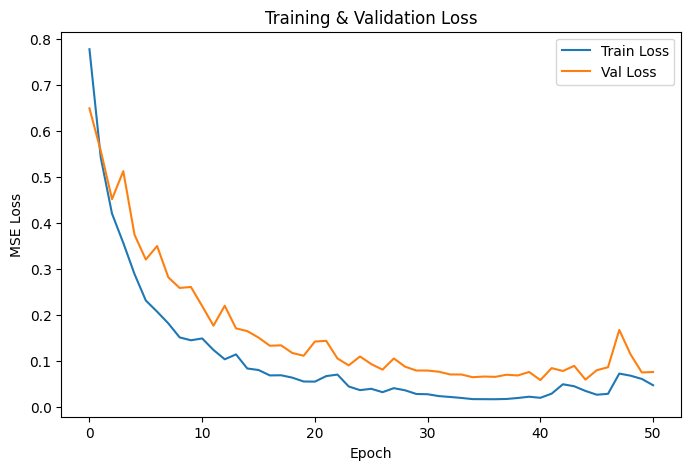

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


# Step 6: Predictions and Inverse Transform

In [11]:
model.eval()
test_preds_scaled = []
test_targets_scaled = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_batch).squeeze(-1)

        test_preds_scaled.append(preds.cpu().numpy())
        test_targets_scaled.append(y_batch.cpu().numpy())

test_preds_scaled = np.concatenate(test_preds_scaled)
test_targets_scaled = np.concatenate(test_targets_scaled)

# Inverse transform if you scaled the target
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
test_targets = scaler_y.inverse_transform(test_targets_scaled.reshape(-1, 1)).flatten()

# Calculate the final test MSE or RMSE
mse_test = np.mean((test_preds - test_targets)**2)
rmse_test = np.sqrt(mse_test)
print(f"Test MSE:  {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# Display a small sample of true vs predicted
print("\nSample of predictions vs true values:")
for i in range(5):
    print(f"Predicted: {test_preds[i]:.4f},  True: {test_targets[i]:.4f},  Diff: {test_preds[i] - test_targets[i]:.4f}")


Test MSE:  0.0031
Test RMSE: 0.0561

Sample of predictions vs true values:
Predicted: 0.7420,  True: 0.7862,  Diff: -0.0443
Predicted: 0.9102,  True: 0.9167,  Diff: -0.0065
Predicted: 0.7486,  True: 0.7405,  Diff: 0.0082
Predicted: 0.8529,  True: 0.8399,  Diff: 0.0130
Predicted: 0.8227,  True: 0.8537,  Diff: -0.0310


In [12]:
# Step 1: Setup

In [ ]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")



Dataset saved to ./kiwi/airfoil_data.csv


## Step 

## Step 2: Load surrogate model from engiopt

In [14]:
dataset.column_names

['initial',
 'optimized',
 'mach',
 'reynolds',
 'cl_target',
 'area_target',
 'alpha',
 'area_initial',
 'cd_val',
 'cl_val',
 'cl_con',
 'area_con']

In [14]:
import sys
import os

# Add the path to the directory containing your AutoGluon script
sys.path.append(os.path.abspath("../EngiOpt/engiopt"))

# Now you can import and use the script as if it's in the same directory
#from autogluon_multimodal import main


# CHECKED:

# data_dir
# data_input
# input_cols
# target_col
# flatten_columns
# hidden_layers
# activation
# optimizer
# learning_rate
# n_epochs
# batch_size
# patience
# scale_target
# wandb_project
# seed
# save_model
# track
# model_output_dir
# wandb_project


!python ./engiopt/sm_vae_1D.py \
    --data_dir "../EngiOpt/data" \
    --data_input "airfoil_data.csv" \
    --input_cols '["optimized","mach","reynolds","alpha"]' \
    --target_col "cl_val" \
    --flatten_columns '["optimized"]' \
    --structured  \
    --latent_dim 10 \
    --hidden_layers 2 \
    --hidden_size 64 \
    --activation relu \
    --optimizer adam \
    --learning_rate 1e-3 \
    --n_epochs 300 \
    --batch_size 32 \
    --patience 50 \
    --scale_target \
    --track \
    --seed 42 \
    --save_model \
    --model_output_dir "my_models"

wandb: Currently logged in as: smassoudi (smassoudi-eth-z-rich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.5
wandb: Run data is saved locally in /Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/wandb/run-20250318_153311-zim5k8d3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run airfoil_data.csv__seed42__2025-03-18-15-33-10
wandb: ⭐️ View project at https://wandb.ai/smassoudi-eth-z-rich/sm_vae_1D
wandb: 🚀 View run at https://wandb.ai/smassoudi-eth-z-rich/sm_vae_1D/runs/zim5k8d3
Using device: mps
/Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/./engiopt/sm_vae_1D.py:288: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results 